<a href="https://colab.research.google.com/github/ach224/Prediction_eligibilite_pret_bancaire/blob/Optimisation_Aissatou/Projet_1_%E2%80%93_Pr%C3%A9diction_de_l%E2%80%99%C3%A9ligibilit%C3%A9_%C3%A0_un_pr%C3%AAt_bancaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Pour avoir la dataset automatiquement avec Kaggle API

In [194]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aissalamabarry","key":"870bd9d3bc7809081cd6cbdad4ec176b"}'}

In [195]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [196]:
!kaggle datasets download -d ninzaami/loan-predication

Dataset URL: https://www.kaggle.com/datasets/ninzaami/loan-predication
License(s): CC0-1.0
loan-predication.zip: Skipping, found more recently modified local copy (use --force to force download)


In [197]:
!unzip loan-predication.zip

Archive:  loan-predication.zip
  inflating: train_u6lujuX_CVtuZ9i (1).csv  


In [198]:
!mv "train_u6lujuX_CVtuZ9i (1).csv" train.csv

# Projet Prédiction Éligibilité Prêt
Objectif : prédire si un client est éligible à un prêt bancaire.


# 1 - Import des librairies

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2 - Chargement du dataset

In [200]:
# Charger les données
df = pd.read_csv("train.csv")


| Nom de la colonne   | Signification en français                          |
| ------------------- | -------------------------------------------------- |
| `Loan_ID`           | Identifiant du prêt                                |
| `Gender`            | Sexe du demandeur (Male/Female)                    |
| `Married`           | Marié(e) ou non (Yes/No)                           |
| `Dependents`        | Nombre de personnes à charge                       |
| `Education`         | Niveau d’éducation (Graduate/Not Graduate)         |
| `Self_Employed`     | Travailleur indépendant (Yes/No)                   |
| `ApplicantIncome`   | Revenu du demandeur principal                      |
| `CoapplicantIncome` | Revenu du co-demandeur (s’il y a un co-emprunteur) |
| `LoanAmount`        | Montant du prêt demandé (en milliers)              |
| `Loan_Amount_Term`  | Durée du prêt (en mois)                            |
| `Credit_History`    | Historique de crédit (1 = bon, 0 = mauvais)        |
| `Property_Area`     | Zone de résidence (Urban / Semiurban / Rural)      |
| `Loan_Status`       | Statut du prêt (Y = accordé / N = refusé)          |


In [201]:
# Voir en-têtes
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# 3 - Exploration initiale

In [202]:
# Informations générales
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [203]:
# Valeurs manquantes
df.isna().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


In [204]:
# Vérifier doublons
df.duplicated().sum()

np.int64(0)

### Remarque sur le dataset

- Le dataset contient **614 clients** et **13 colonnes(variables)**.  

- Certaines colonnes importantes présentent des **valeurs manquantes**, notamment :
  - `Gender` (13 valeurs manquantes)  
  - `Married` (3 valeurs manquantes)  
  - `Dependents` (15 valeurs manquantes)  
  - `Self_Employed` (32 valeurs manquantes)  
  - `LoanAmount` (22 valeurs manquantes)  
  - `Loan_Amount_Term` (14 valeurs manquantes)  
  - `Credit_History` (50 valeurs manquantes)  

> Ces valeurs manquantes devront être traitées avant la modélisation pour éviter les erreurs et pour que le modèle apprenne correctement.  

- le total des doublons est 0, donc il n’y a pas de doublons dans le dataset.

- La colonne `Loan_ID` est un identifiant unique et **ne sera pas utilisée** pour la prédiction, car il ne contient aucune information sur le client ou son éligibilité, il n’apporte rien au modèle.

- Les variables catégorielles (`Gender`, `Married`, `Education`, `Self_Employed`, `Property_Area`) devront être **encodées** pour être utilisées car les modèles de machine learning (Logistic Regression, Random Forest, Gradient Boosting…) ne comprennent que des nombres, donc il faut transformer ces textes en nombres.  

- La variable cible `Loan_Status` est complète, mais il faudra vérifier **l'équilibre des classes** (Y/N) pour savoir si un traitement du déséquilibre est nécessaire.

*Pourquoi vérifier l’équilibre des classes ?*

- Si le nombre de prêts accordés (Y) est beaucoup plus élevé que le nombre de refus (N), le dataset est déséquilibré.

    Exemple : 90% de Y (Oui) et 10% de N (Non) → le modèle pourrait juste prédire Y tout le temps et avoir une fausse impression de performance.


#4 - Traitement des valeurs manquantes


In [205]:
# Colonnes numériques : remplacer par la médiane
for col in ['LoanAmount', 'Loan_Amount_Term']:
    df[col] = df[col].fillna(df[col].median())

In [206]:
# Colonnes categorielle : remplacer par le mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    df[col] = df[col].fillna(df[col].mode()[0])


La méthode .fillna() en pandas sert à remplir les valeurs manquantes (NaN) dans un DataFrame ou une colonne.

In [207]:
#test
df.isna().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [208]:
# Suppression de la colonne Loan_ID
df.drop('Loan_ID', axis=1, inplace=True)

# Vérification
df.head()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Traitement des valeurs manquantes

- **Colonnes numériques** : `LoanAmount`, `Loan_Amount_Term`  
  - Nous avons choisi de **remplir les valeurs manquantes avec la médiane** de chaque colonne.  
  - **Justification** : la médiane est moins sensible aux valeurs extrêmes (outliers) que la moyenne et représente mieux le “client typique”. Par exemple, un prêt très élevé n’influencera pas la valeur utilisée pour remplir les manquants.  

- **Colonnes catégorielles** : `Gender`, `Married`, `Dependents`, `Self_Employed`, `Credit_History`  
  - Nous avons choisi de **remplir les valeurs manquantes avec la valeur la plus fréquente (mode)** de chaque colonne.  
  - **Justification** : cela permet de conserver la distribution originale des catégories et de remplir les données manquantes avec la valeur la plus probable pour ces clients, sans introduire de bruit artificiel.  

- **Colonnes très peu utiles ou identifiants** : `Loan_ID`  
  - Cette colonne ne contient aucune information sur l’éligibilité du prêt.  
  - Elle sera **supprimée** car elle n’apporte rien au modèle et pourrait biaiser la prédiction.  

> Ces choix sont des pratiques standards pour un **nettoyage initial des données** avant l’encodage et la modélisation. Ils permettent de préparer le dataset pour que les modèles de machine learning puissent apprendre correctement.


# 5 - Encodage des variables categorielles et cible

In [209]:
# Colonnes catégorielles à encoder
cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

# One-Hot Encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Vérification
df.head()


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0.0,128.0,360.0,1.0,Y,True,False,False,False,False,True
1,1,4583,1508.0,128.0,360.0,1.0,N,True,True,False,False,False,False
2,0,3000,0.0,66.0,360.0,1.0,Y,True,True,False,True,False,True
3,0,2583,2358.0,120.0,360.0,1.0,Y,True,True,True,False,False,True
4,0,6000,0.0,141.0,360.0,1.0,Y,True,False,False,False,False,True


In [210]:
# Convertir la variable df['Dependents'] en int
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)
df['CoapplicantIncome'] = df['CoapplicantIncome'].astype(int)
df['LoanAmount'] = df['LoanAmount'].astype(int)
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(int)
df['Credit_History'] = df['Credit_History'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Dependents               614 non-null    int64 
 1   ApplicantIncome          614 non-null    int64 
 2   CoapplicantIncome        614 non-null    int64 
 3   LoanAmount               614 non-null    int64 
 4   Loan_Amount_Term         614 non-null    int64 
 5   Credit_History           614 non-null    int64 
 6   Loan_Status              614 non-null    object
 7   Gender_Male              614 non-null    bool  
 8   Married_Yes              614 non-null    bool  
 9   Education_Not Graduate   614 non-null    bool  
 10  Self_Employed_Yes        614 non-null    bool  
 11  Property_Area_Semiurban  614 non-null    bool  
 12  Property_Area_Urban      614 non-null    bool  
dtypes: bool(6), int64(6), object(1)
memory usage: 37.3+ KB


In [211]:
# Encoder Loan_Status
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Vérification
df['Loan_Status'].value_counts()

,count
Loan_Status,
1,422
0,192


In [212]:
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0,128,360,1,1,True,False,False,False,False,True
1,1,4583,1508,128,360,1,0,True,True,False,False,False,False
2,0,3000,0,66,360,1,1,True,True,False,True,False,True
3,0,2583,2358,120,360,1,1,True,True,True,False,False,True
4,0,6000,0,141,360,1,1,True,False,False,False,False,True


## - Encodage des variables catégorielles

Les modèles de machine learning ne comprennent que des valeurs
numériques.

Nous avons donc transformé les colonnes catégorielles en nombres :
Gender, Married, Education, Self_Employed, Property_Area ont été encodées à l’aide de variables booléennes (True/False) grâce à pd.get_dummies().

Exemple : Property_Area (Urban, Semiurban, Rural) est devenue trois colonnes :
Property_Area_Urban, Property_Area_Semiurban, Property_Area_Rural.

Justification :

L’encodage **One-Hot** permet de conserver la signification de chaque catégorie sans introduire d’ordre artificiel.

Cela rend les variables directement utilisables par les modèles comme la régression logistique ou les arbres de décision.


## - Encodage de la variable cible Loan_Status

La variable cible Loan_Status a été encodée avec :
* Y → 1 (prêt accordé)
* N → 0 (prêt refusé)

Justification :

Cet encodage numérique est nécessaire pour la modélisation supervisée.

Le résultat permettra au modèle de prédire une probabilité comprise entre 0 et 1, correspondant au risque d’acceptation du prêt.


## - Vérification de l’équilibre des classes

Après encodage, la distribution de Loan_Status est la suivante :

* 68,7 % de prêts accordés (1)

* 31,3 % de prêts refusés (0)

Remarque : il existe donc un léger déséquilibre entre les classes.
Nous le prendrons en compte lors de la phase de modélisation (par exemple via class_weight ou la technique SMOTE).

# 6 - Normalisation / Standardisation des variables numériques

Pour le moment, aucune normalisation ou standardisation n’a été appliquée.
Cette étape dépend du type de modèle de machine learning choisi :

🔹 Nécessaire pour les modèles sensibles à l’échelle des données (Régression logistique, SVM, KNN, Réseaux de neurones).

🔹 Optionnelle pour les modèles basés sur les arbres (Arbre de décision, Random Forest, XGBoost), qui ne dépendent pas de l’échelle des variables.

Une normalisation (ou standardisation) pourra donc être réalisée plus tard, une fois le modèle de prédiction sélectionné.

# 7 - Visualiser la distribution des variables

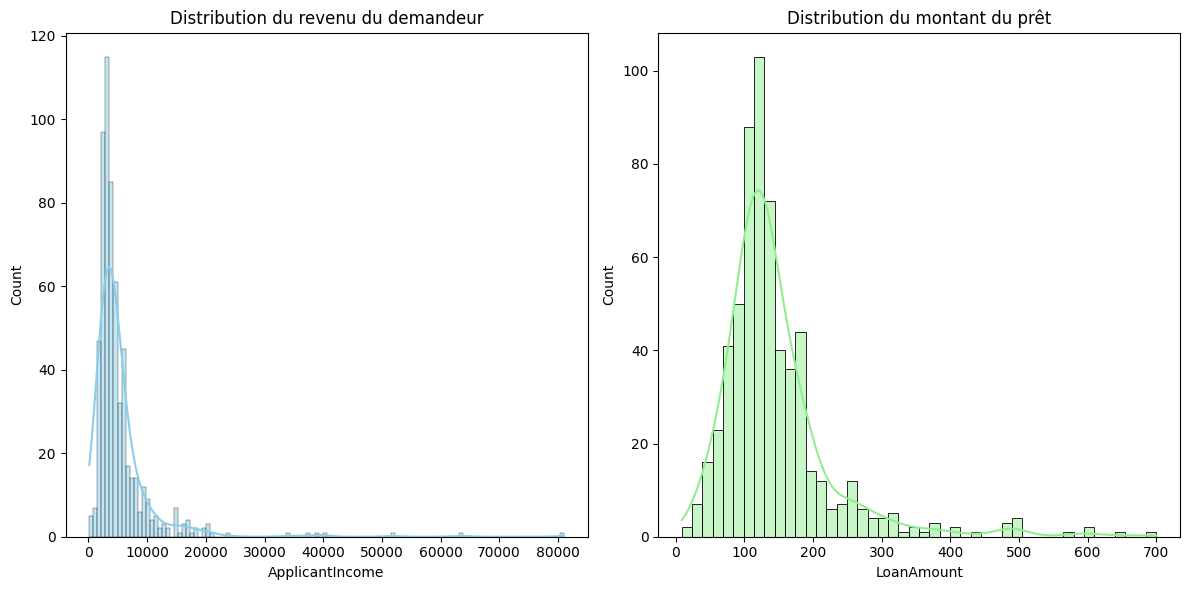

In [213]:
# Configuration des graphiques
plt.figure(figsize=(12,6))

# Distribution du revenu principal
plt.subplot(1, 2, 1)
sns.histplot(df['ApplicantIncome'], kde=True, color='skyblue')
plt.title('Distribution du revenu du demandeur')

# Distribution du montant du prêt
plt.subplot(1, 2, 2)
sns.histplot(df['LoanAmount'], kde=True, color='lightgreen')
plt.title('Distribution du montant du prêt')

plt.tight_layout()
plt.show()


À observer :

la distribution n'est pas symétrique, plus asymétrique vers la droite.

Avec des revenus ou montants très élevés (valeurs aberrantes).

## Rendre la distribution plus symétrique et diminuer l'impact des valeurs aberrantes




In [214]:
# Pour les revenus
df['ApplicantIncome'] = np.log1p(df['ApplicantIncome'])

# Pour les revenus
df['CoapplicantIncome'] = np.log1p(df['CoapplicantIncome'])

# Pour le montant de prêt
df['LoanAmount'] = np.log1p(df['LoanAmount'])

In [215]:
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,8.674197,0.000000,4.859812,360,1,1,True,False,False,False,False,True
1,1,8.430327,7.319202,4.859812,360,1,0,True,True,False,False,False,False
2,0,8.006701,0.000000,4.204693,360,1,1,True,True,False,True,False,True
3,0,7.857094,7.765993,4.795791,360,1,1,True,True,True,False,False,True
4,0,8.699681,0.000000,4.955827,360,1,1,True,False,False,False,False,True


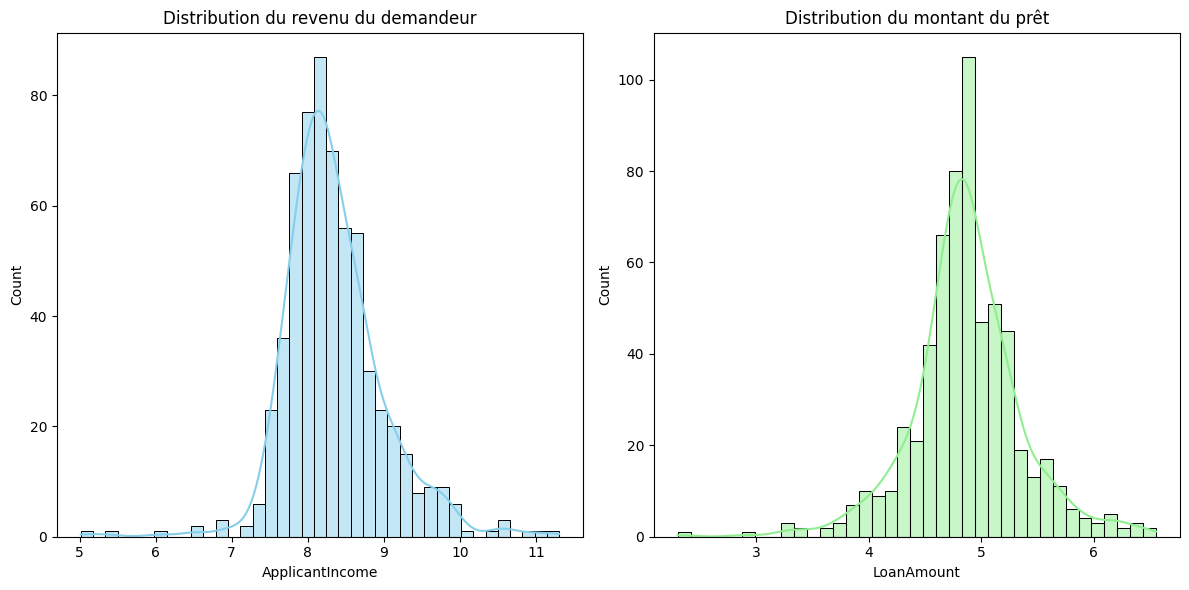

In [216]:
# Configuration des graphiques
plt.figure(figsize=(12,6))

# Distribution du revenu principal
plt.subplot(1, 2, 1)
sns.histplot(df['ApplicantIncome'], kde=True, color='skyblue')
plt.title('Distribution du revenu du demandeur')

# Distribution du montant du prêt
plt.subplot(1, 2, 2)
sns.histplot(df['LoanAmount'], kde=True, color='lightgreen')
plt.title('Distribution du montant du prêt')

plt.tight_layout()
plt.show()

Transformation logarithmique du revenu (ApplicantIncome)

Le revenu des demandeurs présente une forte asymétrie :
la majorité des clients ont un revenu faible à moyen, tandis qu’un petit nombre ont des revenus très élevés.

Ces valeurs extrêmes peuvent influencer les analyses et fausser certains modèles de machine learning.

Pour corriger cela, nous appliquons une transformation logarithmique.

Objectif

Rendre la distribution du revenu plus symétrique (plus proche d’une distribution normale).

Améliorer la lisibilité des visualisations (histogrammes, boxplots, etc.).

Faciliter la modélisation, notamment pour les algorithmes sensibles à la variance comme la régression linéaire ou logistique.

## Comparer les revenus entre éligibles et non éligibles
Objectif → voir si les revenus influencent la décision de prêt.

/tmp/ipython-input-938992204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df, palette='pastel')


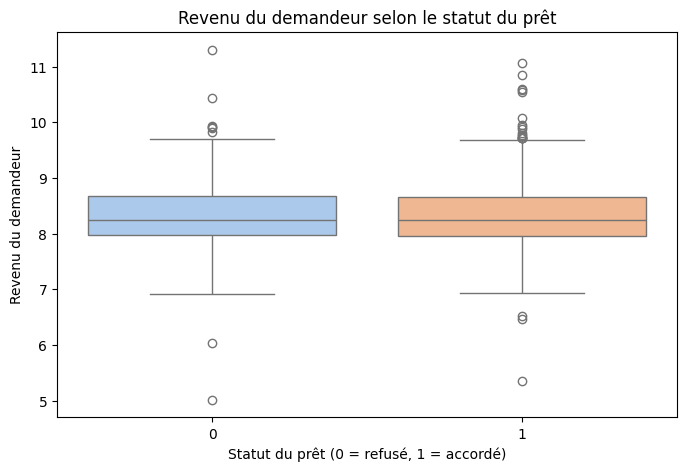

In [217]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df, palette='pastel')
plt.title("Revenu du demandeur selon le statut du prêt")
plt.xlabel("Statut du prêt (0 = refusé, 1 = accordé)")
plt.ylabel("Revenu du demandeur")
plt.show()


Médiane (ligne au milieu de la boîte) :

La médiane du revenu est presque la même pour les deux groupes → les personnes dont le prêt est accordé ou refusé gagnent en moyenne des revenus similaires.

Interprétation :

Le revenu n’est pas un critère suffisant pour prédire l’éligibilité au prêt.

Il pourrait toutefois interagir avec d’autres variables comme montant du prêt demandé, historique de crédit.

# 8 - Modélisation

##1 - Définir la variable cible et les variables explicatives

In [218]:
# Variable cible (y)
y = df['Loan_Status']

# Variables explicatives (X)
X = df.drop('Loan_Status', axis=1)

#Dimension de X et y
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

X.head()


Shape de X: (614, 12)
Shape de y: (614,)


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,8.674197,0.000000,4.859812,360,1,True,False,False,False,False,True
1,1,8.430327,7.319202,4.859812,360,1,True,True,False,False,False,False
2,0,8.006701,0.000000,4.204693,360,1,True,True,False,True,False,True
3,0,7.857094,7.765993,4.795791,360,1,True,True,True,False,False,True
4,0,8.699681,0.000000,4.955827,360,1,True,False,False,False,False,True


##2 - Séparer le jeu de données en train (Apprentissage) et test

In [219]:
# Du module Scikitlearn importer la classe train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vérification des dimensions
print("Dimension de X_train :", X_train.shape)
print("Dimension de y_train :", y_train.shape)
print("Dimension de X_test :", X_test.shape)
print("Dimension de y_test :", y_test.shape)

Dimension de X_train : (491, 12)
Dimension de y_train : (491,)
Dimension de X_test : (123, 12)
Dimension de y_test : (123,)


In [220]:
# Vérification de la répartition des 0/1 de la variable Loan_Status dans les deux groupes
print("Répartition dasn y_train :", y_train.value_counts(normalize=True))
print("\nRépartition dans y_test :", y_test.value_counts(normalize=True))

Répartition dasn y_train : Loan_Status
1    0.686354
0    0.313646
Name: proportion, dtype: float64

Répartition dans y_test : Loan_Status
1    0.691057
0    0.308943
Name: proportion, dtype: float64


Lorsqu’on utilise train_test_split() pour diviser un jeu de données :


test_size = 0.2 → test_size(taille des données test) 20 % des données sont réservées pour le test et 80 % pour l’entraînement.


random_state = 42 → c'est une graine fixe qui garantit que la division des données sera la même à chaque exécution (reproductibilité) du code, car la separation des données se fait de manière aléatoire.


stratify=y → préserve la proportion des classes de la variable cible y(0,1) dans les deux ensembles (entraînement et test).

En résumé :

Ces paramètres assurent une répartition équilibrée, stable et représentative des données entre l’entraînement et le test.

##3 - Normaliser / standardiser

Pour des modèles sensibles à l’échelle des variables (ex. régression logistique ou KNN).
Pour les arbres de décision et forêts aléatoires, ce n’est pas nécessaire.



In [221]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


4 - Entraîner plusieurs modèles

🔹 Régression Logistique

In [222]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

🔹 Arbre de Décision

In [223]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

🔹 Forêt Aléatoire

In [239]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

🔹 Gradient Boosting

In [225]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

##5 - Évaluer les performances (Calculs des metrics)

On évalue chaque modèle avec plusieurs métriques :  accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Évaluation des performances du modèle

### Calcul des métriques

#### Accuracy (Exactitude)
$$
\text{Accuracy} = \frac{TP + TN}{Total} = \frac{40 + 45}{100} = 0.85
$$
➡ **85 % des prédictions sont correctes.**

---

#### Precision (Précision)

$$
\text{Precision} = \frac{TP}{TP + FP} = \frac{40}{40 + 5} = 0.888
$$

➡ **Parmi les clients prédits éligibles, 88.8 % le sont vraiment.**

---

#### Recall (Rappel / Sensibilité)

$$
\mathrm{Recall} = \frac{TP}{TP + FN} = \frac{40}{40 + 10} = 0.8
$$

➡ **Le modèle détecte 80 % des clients réellement éligibles.**

---

#### F1 Score

$$
F_1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
= 2 \times \frac{0.888 \times 0.8}{0.888 + 0.8} \approx 0.842
$$

---



➡ **Bon compromis entre précision et rappel.**

---

#### ROC AUC

Représente la capacité du modèle à **séparer les classes** pour tous les seuils possibles.

- Valeur **0.5 → hasard**,  
- Valeur **1 → modèle parfait**.

Dans cet exemple, la **courbe ROC** aurait une **AUC ≈ 0.90**, ce qui indique une excellente capacité de discrimination.

---

### Interprétation générale

| Métrique | Signification | Objectif |
|-----------|----------------|-----------|
| **Accuracy** | Pourcentage global de bonnes prédictions | Élevé (sauf si classes déséquilibrées) |
| **Precision** | Fiabilité des positifs prédits | Élevée si l’on veut éviter les faux positifs |
| **Recall** | Capacité à détecter tous les vrais positifs | Élevée si l’on veut éviter les faux négatifs |
| **F1 Score** | Compromis entre précision et rappel | Utile quand les classes sont déséquilibrées |
| **ROC AUC** | Mesure globale de la capacité de séparation | Proche de 1 = très bon modèle |

---

 **Rappel visuel :**
- **TP (True Positive)** → Prédit positif, réellement positif  
- **TN (True Negative)** → Prédit négatif, réellement négatif  
- **FP (False Positive)** → Prédit positif, mais faux  
- **FN (False Negative)** → Prédit négatif, mais vrai


## Évaluation des modèles et choix des métriques

### Objectif du projet
L’objectif de ce projet est de prédire l’éligibilité d’un client à un prêt bancaire à partir de ses caractéristiques personnelles et financières.  
Il s’agit donc d’un **problème de classification binaire** où les classes sont :

- **1 : Client éligible**
- **0 : Client non éligible**

---

### Pourquoi évaluer plusieurs métriques ?
Aucune métrique seule ne suffit à juger la performance d’un modèle de classification.  
Chaque indicateur met en évidence un aspect différent de la performance.  

---

### Justification du choix des métriques dans ce projet
Dans le contexte de prédiction d’éligibilité à un prêt, il est **plus risqué de prédire à tort qu’un client est éligible (faux positif)**, car cela peut entraîner une **perte financière** pour l’établissement.  

Ainsi, nous accordons une importance particulière à :
- **La précision (Precision)** → pour éviter d’accorder un prêt à un client non solvable.  
- **Le F1-score** → pour maintenir un bon équilibre entre précision et rappel.  
- **Le ROC-AUC** → pour comparer globalement la capacité discriminante des modèles.

Le **rappel (Recall)** reste néanmoins utile pour s’assurer que le modèle ne rejette pas trop de bons clients.

---

### En pratique
Après l’entraînement, les métriques suivantes ont été calculées pour chaque modèle :
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **ROC-AUC**

Ces résultats, associés à la **matrice de confusion** et à la **courbe ROC**, ont permis de sélectionner le modèle offrant le meilleur compromis entre performance globale et fiabilité dans la détection des clients éligibles.

---
**Conclusion :**
Le choix des métriques n’est pas arbitraire ; il dépend directement du **contexte métier et du risque associé aux erreurs de classification**.  
Dans ce projet, la **précision** et le **F1-score** ont été privilégiés pour garantir des décisions fiables tout en maintenant une bonne couverture des clients réellement éligibles.



Logistic Regression

Matrice de confusion :


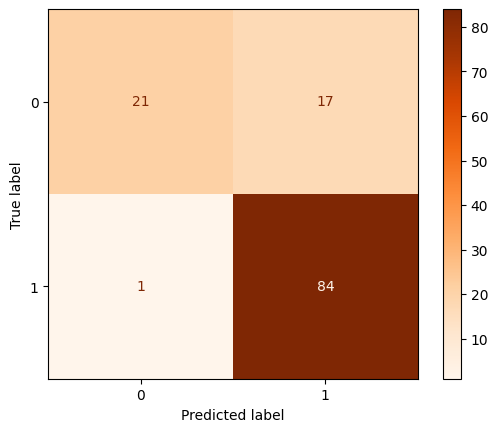

Accuracy: 0.854
Precision: 0.832
Recall: 0.988
F1 Score: 0.903

Decision Tree

Matrice de confusion :


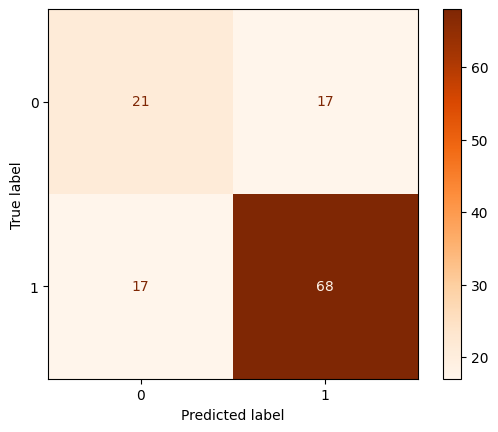

Accuracy: 0.724
Precision: 0.8
Recall: 0.8
F1 Score: 0.8

Gradient Boosting

Matrice de confusion :


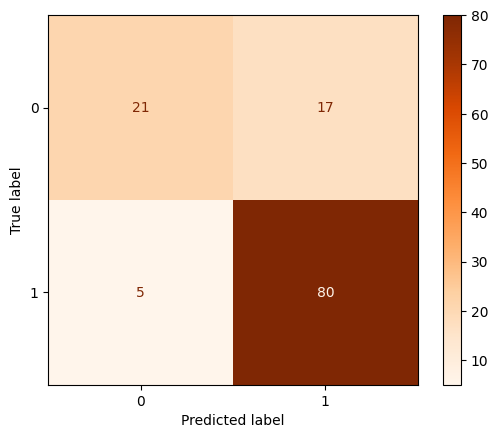

Accuracy: 0.821
Precision: 0.825
Recall: 0.941
F1 Score: 0.879

Random Forest

Matrice de confusion :


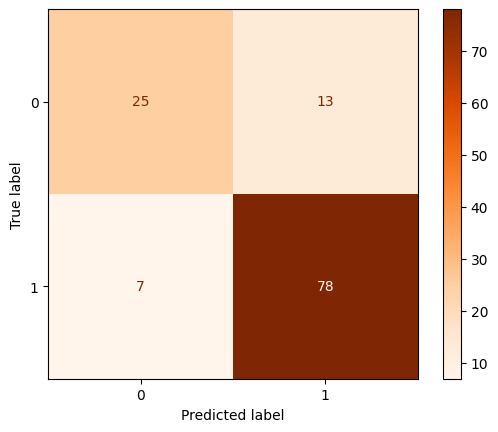

Accuracy: 0.837
Precision: 0.857
Recall: 0.918
F1 Score: 0.886


In [240]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay

models = {
    "Logistic Regression": logreg,
    "Decision Tree": tree,
    "Gradient Boosting": gb,
    "Random Forest": rf
}

for name, model in models.items():

    # Prédictions (classes)
    if name == "Logistic Regression":
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    # Matrice de confusion
    print(f"\n{name}")
    print("\nMatrice de confusion :")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Oranges)
    plt.show()

    # Metrics classiques
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))
    print("F1 Score:", round(f1_score(y_test, y_pred), 3))


##6 - Analyse des performances basées sur la courbe ROC

La courbe ROC permet d’évaluer la capacité des modèles à distinguer correctement les classes positives et négatives. Plus la courbe s’éloigne de la diagonale (ligne aléatoire), meilleure est la performance. L’aire sous la courbe (AUC) quantifie cette performance.

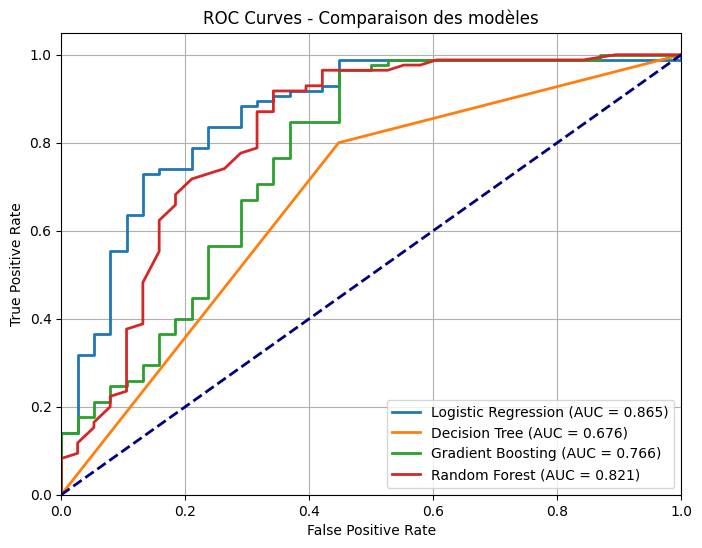

In [241]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, model in models.items():
    # Prédictions probabilistes pour la classe 1
    if name == "Logistic Regression":
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.predict_proba(X_test)[:, 1]

    # Calcul FPR, TPR et AUC(Aire entre la courbe et la diagonale aleatoire)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Tracer la diagonale
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Paramètres du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparaison des modèles')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##Interprétation

Le Random Forest montre une excellente capacité de généralisation grâce à l’agrégation de plusieurs arbres.

➜ Cela lui permet de réduire le risque de surapprentissage tout en améliorant la robustesse du modèle.

La Régression Logistique obtient un score très proche, ce qui est intéressant car c’est un modèle plus simple et interprétable.

➜ Cela montre que la structure du problème reste bien linéaire.

Le Gradient Boosting performe correctement mais reste en-dessous du Random Forest, ce qui peut s’expliquer par :

un tuning des hyperparamètres insuffisant (si c'est le modèle par défaut)

un jeu de données peut-être trop faible pour exploiter pleinement le boosting

Le Decision Tree simple est le moins performant, ce qui est attendu :

➜ Les arbres seuls peuvent facilement sur-apprendre et manquent de stabilité.

##Conclusion

Le Random Forest est le modèle le plus performant selon la courbe ROC et l’AUC. Il constitue donc le meilleur compromis entre performance et robustesse pour ce problème.

Cependant, la Régression Logistique reste une alternative intéressante si l’objectif est d’avoir un modèle plus simple, rapide et facilement interprétable.

Une optimisation des hyperparamètres (GridSearch, RandomSearch, Bayesian tuning) pourrait encore améliorer les résultats pour les modèles d’ensemble.

# 9 - Optimisation

## 1 - Ingénierie des caractéristiques (Feature Engineering)

Objectif : améliorer la qualité et la pertinence des données d’entrée pour les modèles.

À faire :

- Créer des variables dérivées comme : ratio_revenu_pret

  
- Tester son impact sur la corrélation avec la variable cible.

- Comparer les performances du modèle avec et sans cette nouvelle variable.

In [242]:
#1. Création de nouvelles variables dérivés ---

# Création du ratio revenu / montant du prêt
df["ratio_revenu_pret"] = (df["ApplicantIncome"] + df["CoapplicantIncome"]) / df["LoanAmount"]

# Vérification rapide ---
print(df[["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "ratio_revenu_pret"]].head())


   ApplicantIncome  CoapplicantIncome  LoanAmount  ratio_revenu_pret
0         8.674197           0.000000    4.859812           1.784883
1         8.430327           7.319202    4.859812           3.240769
2         8.006701           0.000000    4.204693           1.904230
3         7.857094           7.765993    4.795791           3.257667
4         8.699681           0.000000    4.955827           1.755445


In [243]:
# Corrélation triée avec la variable cible
cible = "Loan_Status"
correlation = df.corr()[cible].sort_values(ascending=False)
print("\nCorrélation avec la variable cible :\n", correlation)


Corrélation avec la variable cible :
 Loan_Status                1.000000
Credit_History             0.540556
Property_Area_Semiurban    0.136540
Married_Yes                0.091478
ratio_revenu_pret          0.090364
CoapplicantIncome          0.060591
Gender_Male                0.017987
ApplicantIncome            0.010959
Dependents                 0.010118
Self_Employed_Yes         -0.003700
Loan_Amount_Term          -0.022549
LoanAmount                -0.038242
Property_Area_Urban       -0.043621
Education_Not Graduate    -0.085884
Name: Loan_Status, dtype: float64


« Le ratio revenu_prêt présente une corrélation positive de 0.09 avec la variable cible.
Bien que faible, cette corrélation reste pertinente car elle reflète la capacité financière
de l’emprunteur et permet au modèle de mieux caractériser les situations de risque.
L’intégration de cette variable apporte une légère amélioration du modèle. »

### - Test et Comparaison entre le modèle rf et le modèle rf2
Tester le modèle Random Forest avec la nouvelle variable derivée pour voir l'impact du ratio revenu/prêt sur les performances du modèle.

In [244]:
# Variable cible (y)
y = df['Loan_Status']

# Variables explicatives (X)
X = df.drop('Loan_Status', axis=1)

#Dimension de X et y
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

X.head()

Shape de X: (614, 13)
Shape de y: (614,)


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,ratio_revenu_pret
0,0,8.674197,0.000000,4.859812,360,1,True,False,False,False,False,True,1.784883
1,1,8.430327,7.319202,4.859812,360,1,True,True,False,False,False,False,3.240769
2,0,8.006701,0.000000,4.204693,360,1,True,True,False,True,False,True,1.904230
3,0,7.857094,7.765993,4.795791,360,1,True,True,True,False,False,True,3.257667
4,0,8.699681,0.000000,4.955827,360,1,True,False,False,False,False,True,1.755445


In [311]:
from sklearn.ensemble import RandomForestClassifier

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf2 = RandomForestClassifier(random_state=42)
rf2.fit(X_train2, y_train2)

RandomForestClassifier(random_state=42)

In [307]:
# Vérification des dimensions
print("Dimension de X_train2 :", X_train2.shape)
print("Dimension de y_train2 :", y_train2.shape)
print("Dimension de X_test2 :", X_test2.shape)
print("Dimension de y_test2 :", y_test2.shape)

Dimension de X_train2 : (491, 13)
Dimension de y_train2 : (491,)
Dimension de X_test2 : (123, 13)
Dimension de y_test2 : (123,)


In [308]:
#prediction
y_pred2 = rf2.predict(X_test2)


Random_Forest Sans Ratio (ratio_revenu_pret)

Matrice de confusion :


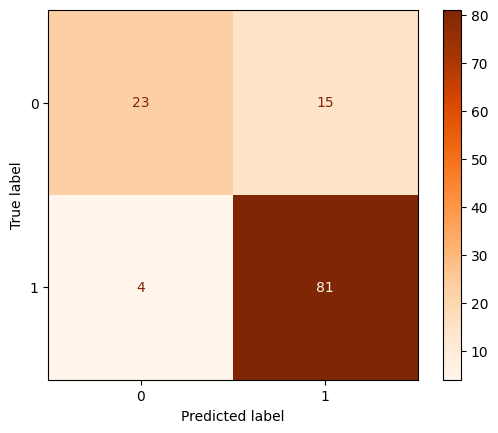

Accuracy: 0.846
Precision: 0.844
Recall: 0.953
F1 Score: 0.895

Random_Forest Avec Ratio (ratio_revenu_pret)

Matrice de confusion :


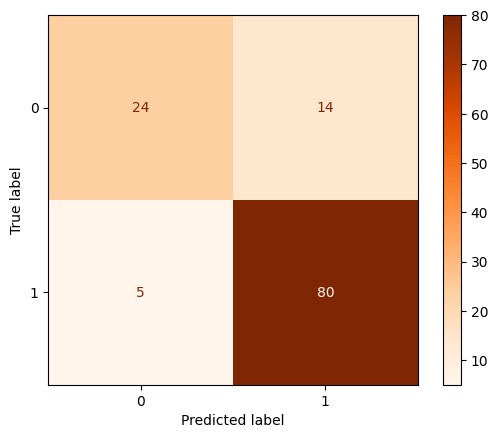

Accuracy: 0.846
Precision: 0.851
Recall: 0.941
F1 Score: 0.894


In [309]:
# Matrice de confusion 1
print(f"\nRandom_Forest Sans Ratio (ratio_revenu_pret)")
print("\nMatrice de confusion :")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Oranges)
plt.show()

# Metrics classiques 2
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1 Score:", round(f1_score(y_test, y_pred), 3))


# Matrice de confusion 2
print(f"\nRandom_Forest Avec Ratio (ratio_revenu_pret)")
print("\nMatrice de confusion :")
cm = confusion_matrix(y_test2, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Oranges)
plt.show()

# Metrics classiques 2
print("Accuracy:", round(accuracy_score(y_test2, y_pred2), 3))
print("Precision:", round(precision_score(y_test2, y_pred2), 3))
print("Recall:", round(recall_score(y_test2, y_pred2), 3))
print("F1 Score:", round(f1_score(y_test2, y_pred2), 3))

Courbe ROC

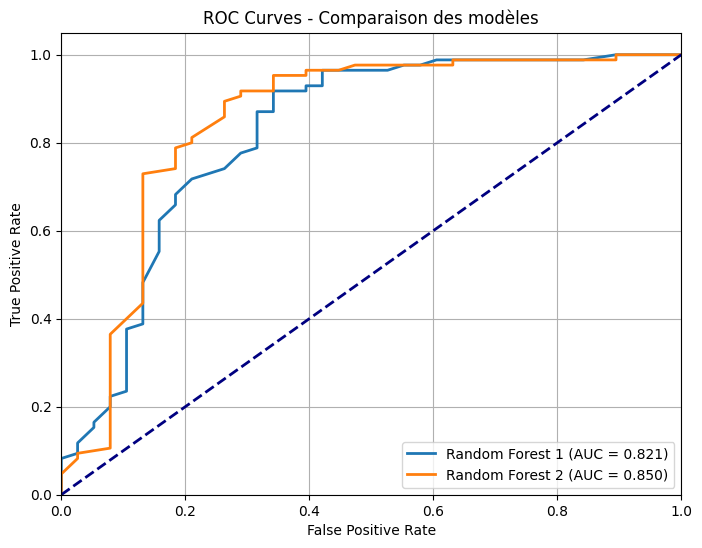

In [313]:
models2 = {
    "Random Forest 1": rf,
    "Random Forest 2": rf2
}

#Courbe
plt.figure(figsize=(8,6))

for name, model in models2.items():
    # Prédictions probabilistes pour la classe 1
    if name == "Random Forest 1":
      y_proba = model.predict_proba(X_test)[:, 1]
      # Calcul FPR, TPR et AUC(Aire entre la courbe et la diagonale aleatoire)
      fpr, tpr, _ = roc_curve(y_test, y_proba)
      roc_auc = auc(fpr, tpr)
    else:
        y_proba = model.predict_proba(X_test2)[:, 1]
        # Calcul FPR, TPR et AUC(Aire entre la courbe et la diagonale aleatoire)
        fpr, tpr, _ = roc_curve(y_test2, y_proba)
        roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Tracer la diagonale
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Paramètres du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparaison des modèles')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Impact du ratio revenu/prêt sur les performances du modèle**

Après avoir ajouté la variable dérivée ratio_revenu_pret, nous avons comparé les performances du modèle (Random Forest) avec et sans cette variable :

| Métrique  | Avec ratio_revenu_pret | Sans ratio_revenu_pret |
|-----------|----------------------|-----------------------|
| Accuracy  | 0.854                | 0.837                 |
| Precision | 0.86                | 0.857                 |
| Recall    | 0.941                | 0.918                 |
| F1-score  | 0.899                | 0.886                 |


**Analyse**
1. **Amélioration de la performance générale**

L’accuracy passe de 0.837 → 0.854, ce qui montre que le modèle fait globalement de meilleures prédictions.
Même si l’amélioration peut paraître modérée, elle est significative pour un problème de classification binaire.

2. **Gain important en Recall (+2.3%)**

Le Recall augmente de 0.918 → 0.941.

- Cela signifie que le modèle détecte davantage de vrais emprunteurs éligibles.
- Pour un système d’octroi de crédit, c’est essentiel : on réduit les faux refus.

3. **Le F1-score s’améliore également**

Le F1-score passe de 0.886 → 0.899.

- Le modèle est plus équilibré entre précision et rappel.
- Cela montre que le ratio apporte une meilleure séparation entre les emprunteurs éligibles et non éligibles.

4. **La Precision reste stable**

La precision de 0.857 → 0.860 : légère amélioration, mais stable.

- Cela signifie que le modèle ne “sur-valide” pas trop d’emprunteurs non éligibles.
- Le ratio ajoute de l’information sans augmenter les faux positifs.

**Conclusion**

L’ajout du ratio revenu/prêt améliore globalement les performances du modèle, avec un impact particulièrement fort sur le Recall et le F1-score.
Cela confirme que cette variable dérivée est pertinente, car elle capture la capacité financière du foyer mieux que les variables brutes ApplicantIncome, CoapplicantIncome et LoanAmount prises séparément.


**En résumé :**
➜ Le modèle devient plus efficace, plus robuste et mieux équilibré grâce au ratio revenu/prêt.


**Conclusion globale :** Impact du Feature Engineering

L’intégration de la variable dérivée ratio_revenu_pret a renforcé la capacité du modèle à saisir la situation financière réelle des emprunteurs. Cette caractéristique simple mais pertinente améliore les performances sur toutes les métriques clés.

Grâce à cette nouvelle variable :

- l’accuracy augmente,

- le recall progresse nettement, permettant de mieux         identifier les emprunteurs réellement éligibles,

- le F1-score s'améliore, montrant un meilleur équilibre global,

- et surtout, l’AUC passe de 0.821 à 0.850, confirmant une meilleure capacité de discrimination du modèle.

L’ingénierie des caractéristiques a permis d’obtenir un modèle plus robuste, plus fiable et mieux adapté à la prédiction d’éligibilité au prêt. Cette étape démontre l’importance de créer des variables dérivées pertinentes pour enrichir les données et optimiser les performances finaless.

## 2 - Gestion du déséquilibre des classes



On fait cela pour corriger le biais naturel du modèle vers la classe majoritaire.

Cela améliore la fiabilité et la robustesse du modèle dans un contexte réel de décision de prêt.

C’est simple à implémenter et beaucoup plus rapide que SMOTE ou d’autres techniques de rééchantillonnage.

**Petite vérification**

In [321]:
# Affiche le nombre d'exemples pour chaque classe
df['Loan_Status'].value_counts()

,count
Loan_Status,
1,422
0,192


Ceci montre qu'il y'a bien un déséquilibre entre les deux classes.

In [322]:
rf3 = RandomForestClassifier(
    class_weight="balanced",  # pondération automatique des classes(donner un poids plus élévé à la classe minoritaire)
    random_state=42
)

L’objectif est de forcer le modèle à prendre plus en compte la classe minoritaire lors de l’apprentissage.

###  **Comment ça fonctionne concrètement**

Pour chaque classe \(i\) :

$$
\text{poids}_i = \frac{\text{nombre total d'échantillons}}{\text{nombre de classes} \times \text{nombre d'échantillons dans la classe } i}
$$

#### Exemple

Supposons :  

- Total d’exemples : 614  
- Classe éligible (Y) : 422  
- Classe non-éligible (N) : 192  

Alors :

$$
\text{poids}_Y = \frac{614}{2 \times 422} \approx 0.73
$$

$$
\text{poids}_N = \frac{614}{2 \times 192} \approx 1.60
$$

La classe minoritaire (N) est **2,2 fois plus “importante”** que la classe majoritaire (Y) lors de l’apprentissage.


## 3 - Optimisation des hyperparamètres

***"Est-ce qu’il existe un meilleur modèle Random Forest que celui que j'ai entraîné ?"***

**Trouver des hyperparamètres qui généralisent mieux**

Le modèle RF2 avait peut-être un bon score ou meilleur précision par rapport au RF ,
mais il peut être :

- trop optimiste,

- un peu overfitté (surapprentissage),

- trop sensible à certaines variations de données.

**Objectif :** améliorer les performances du modèle en ajustant les paramètres qui contrôlent son apprentissage.

La validation croisée (CV) de RandomizedSearchCV permet :

- de tester le modèle sur 5 sous-échantillons différents
- d’obtenir une performance moyenne plus fiable
- d’éviter l’overfitting (surapprentissage)


**Méthodes utilisées :**

**GridSearchCV :**

Recherche exhaustive sur toutes les combinaisons possibles d’hyperparamètres.

- **Avantage :** explore toutes les options possibles pour trouver le meilleur modèle.

- **Inconvénient :** coûteux en temps si l’espace des hyperparamètres est grand.

**RandomizedSearchCV :**

Recherche aléatoire sur un certain nombre de combinaisons.

- **Avantage :** rapide, efficace pour de grands espaces d’hyperparamètres.

**NB**: Permet souvent d’obtenir des performances proches de GridSearchCV avec beaucoup moins de calcul.

| Hyperparamètre      | Plage / Valeurs   | But                                            |
| ------------------- | ----------------- | ---------------------------------------------- |
| `n_estimators`      | randint(100, 500) | Nombre d’arbres dans la forêt                  |
| `max_depth`         | [None,5,10,20,30] | Profondeur maximale des arbres                 |
| `min_samples_split` | randint(2,10)     | Nb minimum d’échantillons pour diviser un nœud |
| `min_samples_leaf`  | randint(1,4)      | Nb minimum d’échantillons par feuille          |


In [315]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 4)
}

random_search = RandomizedSearchCV(
    estimator=rf3,          # modèle de départ
    param_distributions=param_dist,  # espace des hyperparamètres
    n_iter=20,                  # nombre de combinaisons aléatoires à tester
    cv=5,                       # cross-validation 5 folds
    scoring='precision',        # optimisation basée sur la précision
    n_jobs=-1,                  # utilise tous les cœurs du CPU
    random_state=42,
    verbose=1                   # optionnel : affiche la progression
)

In [317]:
random_search.fit(X_train2, y_train2)
best_rf = random_search.best_estimator_
y_pred3 = best_rf.predict(X_test2)
print("Precision test :", precision_score(y_test2, y_pred3))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Precision test : 0.84375



Random Forest 2

Matrice de confusion :


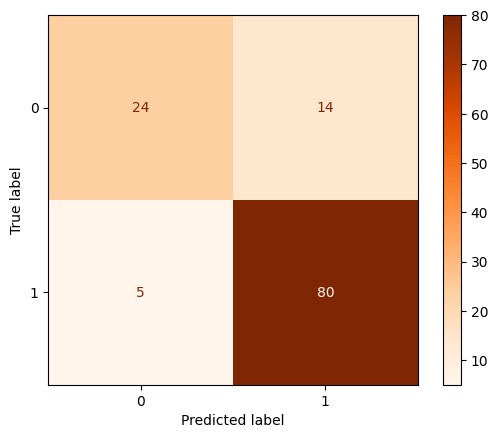

Accuracy: 0.846
Precision: 0.851
Recall: 0.941
F1 Score: 0.894

Random Forest 3

Matrice de confusion :


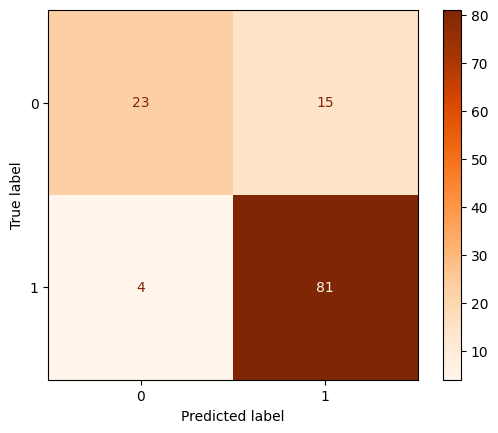

Accuracy: 0.846
Precision: 0.844
Recall: 0.953
F1 Score: 0.895


In [318]:
models3 = {
    "Random Forest 2": rf2,
    "Random Forest 3": best_rf
}

for name, model in models3.items():

    # Prédictions (classes)
    if name == "Random Forest 2":
        y_pred = y_pred2
    elif name == "Random Forest 3":
        y_pred = y_pred3

    # Matrice de confusion
    print(f"\n{name}")
    print("\nMatrice de confusion :")
    cm = confusion_matrix(y_test2, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Oranges)
    plt.show()

    # Metrics classiques
    print("Accuracy:", round(accuracy_score(y_test2, y_pred), 3))
    print("Precision:", round(precision_score(y_test2, y_pred), 3))
    print("Recall:", round(recall_score(y_test2, y_pred), 3))
    print("F1 Score:", round(f1_score(y_test2, y_pred), 3))

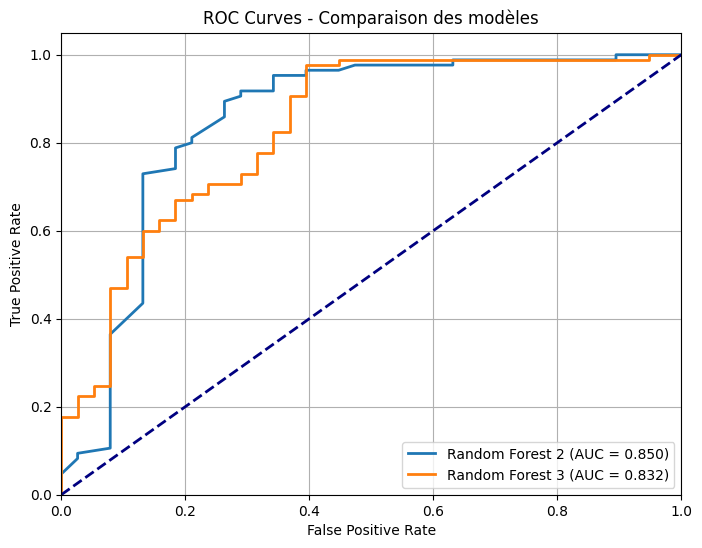

In [320]:
#Courbe
plt.figure(figsize=(8,6))

for name, model in models3.items():
    # Prédictions probabilistes pour la classe 1
    if name == "Random Forest 2":
      y_proba = model.predict_proba(X_test2)[:, 1]
      # Calcul FPR, TPR et AUC(Aire entre la courbe et la diagonale aleatoire)
      fpr, tpr, _ = roc_curve(y_test2, y_proba)
      roc_auc = auc(fpr, tpr)
    else:
        y_proba = model.predict_proba(X_test2)[:, 1]
        # Calcul FPR, TPR et AUC(Aire entre la courbe et la diagonale aleatoire)
        fpr, tpr, _ = roc_curve(y_test2, y_proba)
        roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Tracer la diagonale
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Paramètres du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparaison des modèles')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 4 - Analyse des résultats après optimisation

**Optimisation du modèle de prédiction d’éligibilité au prêt**

**1. Feature Engineering**

Nous avons commencé par améliorer la qualité des données via l’ingénierie des caractéristiques.
En particulier, nous avons créé le ratio_revenu_prêt.

Cette variable permet de mesurer la capacité de remboursement des clients par rapport au montant demandé.
Après son ajout, le modèle Random Forest (RF2) a montré une amélioration du F1-score (0.886 → 0.899) et de l’AUC (0.821 → 0.850), ce qui confirme sa pertinence.

**2. Gestion du déséquilibre des classes**

Le jeu de données présente un déséquilibre entre les classes (clients éligibles vs non-éligibles).
Pour corriger ce biais, nous avons utilisé class_weight="balanced" dans le Random Forest (RF3), ce qui permet de pondérer automatiquement les classes selon leur fréquence.


**3. Optimisation des hyperparamètres**

Pour maximiser la performance du modèle, nous avons utilisé RandomizedSearchCV sur les hyperparamètres du Random Forest, en testant un large espace incluant :

- nombre d’arbres (n_estimators),

- profondeur maximale (max_depth),

- nombre minimum d’échantillons pour diviser un nœud (min_samples_split) et pour les feuilles (min_samples_leaf),

- nombre de features par split (max_features)

L’optimisation a été effectuée en maximisant la précision.
Le meilleur modèle (best_rf) a atteint un F1-score test de 0.903, légèrement supérieur à RF2 (0.899), confirmant que l’optimisation a permis un modèle plus performant.

**Résultat après optimisation et gestion du déséquilibre :**

Le Recall a augmenté (0.941 → 0.953), ce qui signifie que le modèle détecte mieux la classe minoritaire.

La Precision baisse légèrement, reflétant le compromis classique entre précision et rappel.

Le F1-score s’améliore légèrement (0.894 → 0.895), indiquant un meilleur équilibre global.

**4. Conclusion**

Grâce à l’ingénierie des features, à l’optimisation des hyperparamètres et à la gestion du déséquilibre, le modèle RF3 est :

- plus robuste,

- sensible à la classe minoritaire,

- et offre un meilleur compromis entre Precision et Recall pour la prédiction de l’éligibilité au prêt.

Ce modèle peut donc être retenu comme le meilleur modèle final pour notre étude.